# **Problem Statement / Background / Objective**

AllLife Bank wants to focus on its credit card customer base in the next financial year. They have been advised by their marketing research team, that the penetration in the market can be improved. Based on this input, the  Marketing team proposes to run personalised campaigns to target new customers as well as upsell to existing  customers. Another insight from the market  research was that the customers perceive the support services of the bank poorly. Based on this, the Operations team wants to upgrade the service  delivery  model, to ensure that customers queries are resolved faster.

**Objective:** To identify different segments in the existing customer based on their
spending patterns as well as past interaction with the bank.

**Key Questions:**
1. How many different segments of customers are there?
2. How are these segments different from each other?
3. What are your recommendations to the bank on how to better market to and
service these customers?

Steps to follow:
1. **Define the problem and perform an Exploratory Data Analysis**: *Problem definition, questions to be answered - Data background and contents - Univariate analysis - Bivariate analysis* - **8 points**
2. **Illustrate the insights based on EDA**: *Key meaningful observations on individual variables and the relationship between variables* - **7 points**
3. **Data pre-processing**: *Prepare the data for analysis - Feature Engineering - Missing value Treatment - Outlier Treatment - Duplicate observations check and removal if found* - **5 points**
4. **Applying K-means clustering algorithms**: *Apply K-means - Elbow curve - Silhouette Score - figure out appropriate number of cluster* - **10 points**
5. **Applying Hierarchical clustering**: *Apply Hierarchical clustering with different linkage methods - Plot dendrograms for each linkage methods - Choose appropriate number of cluster* - **10 points**
6. **Compare cluster K-means clusters and Hierarchical clusters - Perform cluster profiling - Derive Insights**: *Insights about different clusters* - **10 points**
7. **Actionable Insights & Recommendations**: *Conclude with the key takeaways for the business - What would your buisness recommendation.* - **5 points**
8. **Notebook - Overall**: *Structure and flow - Well commented code* - **5 points**

# **Import & Inspect**

In [ ]:
pip install -U yellowbrick

In [ ]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.patches import FancyBboxPatch
from matplotlib import rcParams
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.metrics import silhouette_score
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import dendrogram, linkage,cophenet
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

#for some of the charts - using fonts that are easy to read - the default font is hard on the eyes
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Tahoma', 'DejaVu Sans',
                               'Lucida Grande', 'Verdana']


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving Credit Card Customer Data.xlsx to Credit Card Customer Data (1).xlsx


In [ ]:
#read data and assign to dataframe
data = pd.read_excel('Credit Card Customer Data.xlsx')

In [ ]:
#make a copy for usage
df = data.copy()

In [ ]:
#number of rows, columns(features)
df.shape

(660, 7)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 660 entries, 0 to 659
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   Sl_No                660 non-null    int64
 1   Customer Key         660 non-null    int64
 2   Avg_Credit_Limit     660 non-null    int64
 3   Total_Credit_Cards   660 non-null    int64
 4   Total_visits_bank    660 non-null    int64
 5   Total_visits_online  660 non-null    int64
 6   Total_calls_made     660 non-null    int64
dtypes: int64(7)
memory usage: 36.2 KB


In [ ]:
#first 5 records of dataframe
df.head()

,Sl_No,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,1,87073,100000,2,1,1,0
1,2,38414,50000,3,0,10,9
2,3,17341,50000,7,1,3,4
3,4,40496,30000,5,1,1,4
4,5,47437,100000,6,0,12,3


In [1]:
#get count of unique values per feature
df.nunique()

NameError: ignored

In [ ]:
#check for null values
df.isna().sum()

Sl_No                  0
Customer Key           0
Avg_Credit_Limit       0
Total_Credit_Cards     0
Total_visits_bank      0
Total_visits_online    0
Total_calls_made       0
dtype: int64

In [ ]:
#check for duplicated rows
df.duplicated().sum()

0

OBSERVATIONS:
  - the dataset contains 660 records and 7 columns (features)

  - all features are of int64 datatype

  - Sl_No appears to be a unique id which is not needed for clustering

  - Customer Key appears to be an access code or PIN which is not needed for clustering. There are 5 duplicated entries in this column. Perhaps this would indicate people using identical PINs. This feature is not useful for clustering.

  - for all other valid columns there are no null values nor duplicate rows

In [ ]:
#dropping columns that are not relevant for clustering
df.drop(['Sl_No','Customer Key'],axis=1,inplace=True)
print(df.shape)
print(df.columns)

(660, 5)
Index(['Avg_Credit_Limit', 'Total_Credit_Cards', 'Total_visits_bank',
       'Total_visits_online', 'Total_calls_made'],
      dtype='object')


In [ ]:
#dataframe summary
df.describe()

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
count,660.000000,660.000000,660.000000,660.000000,660.000000
mean,34574.242424,4.706061,2.403030,2.606061,3.583333
std,37625.487804,2.167835,1.631813,2.935724,2.865317
min,3000.000000,1.000000,0.000000,0.000000,0.000000
25%,10000.000000,3.000000,1.000000,1.000000,1.000000
50%,18000.000000,5.000000,2.000000,2.000000,3.000000
75%,48000.000000,6.000000,4.000000,4.000000,5.000000
max,200000.000000,10.000000,5.000000,15.000000,10.000000


# **Exploratory Data Analysis**

Before performing an Exploratory Data Analysis, I am creating the functions that will generate charts for visual interpretaion

In [ ]:
#Function for continuous numerical histogram/boxplot chart with styling enhancements 
def histogram_boxplot(feature, figsize=(14,5), bins = None):
    f2, (ax_box2, ax_hist2) = plt.subplots(nrows = 2, # Number of rows of the subplot grid= 2
                                           sharex = True, # x-axis will be shared among all subplots
                                           gridspec_kw = {"height_ratios": (.35, .65)}, 
                                           figsize = figsize 
                                           ) 
    sns.boxplot(x=feature, data=df, ax=ax_box2, showmeans=True, color='skyblue', linewidth=6)
    for k,artist in enumerate(ax_box2.artists):
      artist.set_edgecolor('navy')
      for j in range(k*6,k*6+6):
        line = ax_box2.lines[j];line.set_color('navy');line.set_mfc('orange');line.set_mec('orange')
  
    sns.histplot(x=feature, ax=ax_hist2, c='gist_gray_r', data=df, bins=15, stat='density', edgecolor='k', linewidth=2) if bins else sns.histplot(feature, ax=ax_hist2, color='skyblue', bins=15, stat='density', edgecolor='k', linewidth=2) # For histogram
    sns.kdeplot(x=feature, ax=ax_hist2, color='black', data=df, linestyle=":", lw=1)
    ax_box2.grid(False);ax_hist2.grid(False);f2.patch.set_facecolor('#dfe0ed');ax_hist2.set_ylabel('');ax_hist2.set_xlabel('');ax_box2.set_xlabel('')
    ax_box2.set_title(str(feature.name), fontsize=20, fontweight="bold") 
    ax_hist2.axvline(np.mean(feature), color='orange', linestyle='-.', lw=5) # Add mean to the histogram
    ax_hist2.axvline(np.median(feature), color='navy', linestyle='-', lw=5) # Add median to the histogram

In [ ]:
#Function for categorical bar chart with styling enhancements - takes second paramter 'h'. this is for chart height. carts with more features (bars) require greater height
def bar_chart_bar(z,h):
  fig, ax =plt.subplots(figsize=(14, h))
  sns.countplot(y=z, data=df, palette='Blues_r', edgecolor='navy', linewidth='1', joinstyle='bevel')
  ax.set_ylabel('');ax.set_xlabel('');ax.set_title(z, fontsize=20, fontweight="bold");fig.patch.set_facecolor('#dfe0ed');ax.grid(False)
  for p in ax.patches:
          total = len(df[z])
          percentage = '{:.1f}%'.format(100 * p.get_width()/total) + '\n' + str(p.get_width())
          #print(percentage)
          x = p.get_x() + p.get_width()
          y = p.get_y() + p.get_height()
          ax.annotate(percentage, (x+3, y-0.1), size = 12, color='black', fontweight="bold", bbox=dict(boxstyle='round,pad=0.3', fc='orange', alpha=.75))
  plt.show()

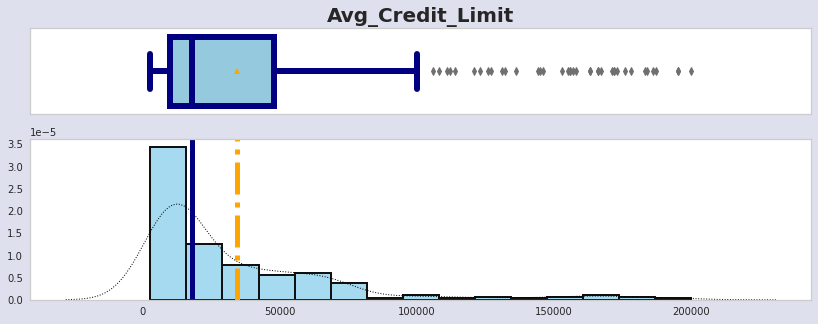

In [ ]:
histogram_boxplot(df['Avg_Credit_Limit'])

`Avg_Credit_Limit` has quite a few outliers above cap with a significant right skew. However, these do not appear to be errors. These appear to be a valid representation of the population. Therefore, these outliers will not be treated.
**`We will see in the cluster analysis below, that these outliers play a signigicant role in clustering which will help us understand the customer segmentation in a way that would be missed if these outliers were to be removed.`**

Mean is `$34,574`

Median is `$18,000`

Significant right skewed distribution

---

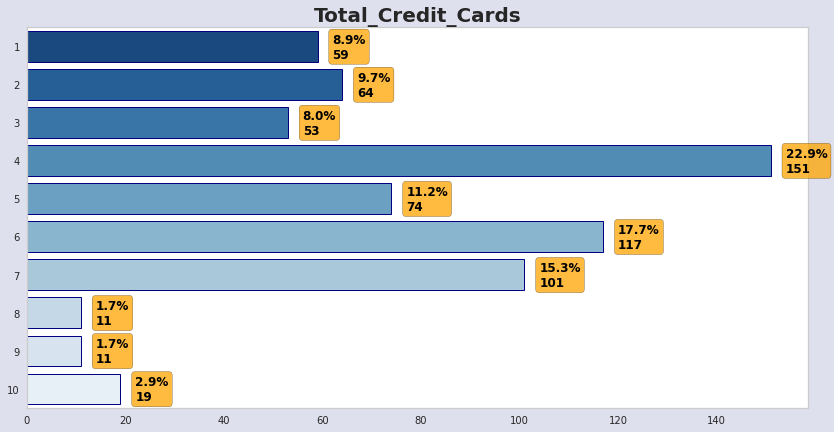

In [ ]:
bar_chart_bar('Total_Credit_Cards', 7)

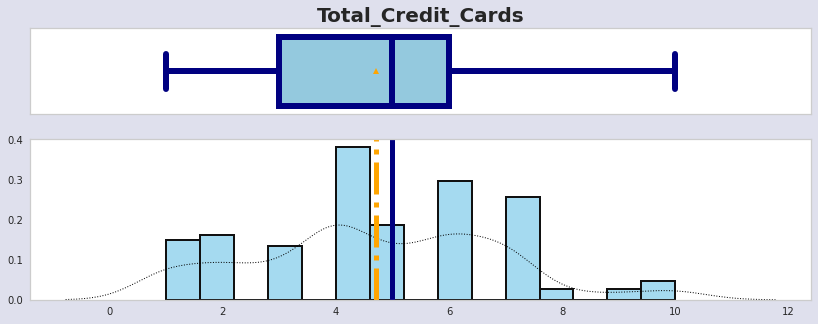

In [ ]:
histogram_boxplot(df['Total_Credit_Cards'])

- 9% of customers have 1 credit card
- 10% of customers have 2 credit cards
- 8% of customers have 3 credit cards
- 23% of customers have 4 credit cards
- 11% of customers have 5 credit cards
- 18% of customers have 6 credit cards
- 15% of customers have 7 credit cards
- 2% of customers have 8 credit cards
- 2% of customers have 9 credit cards
- 3% of customers have 10 credit cards

---

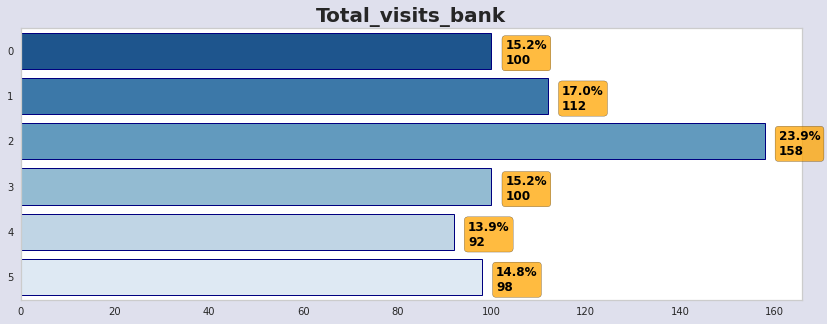

In [ ]:
bar_chart_bar('Total_visits_bank', 5)

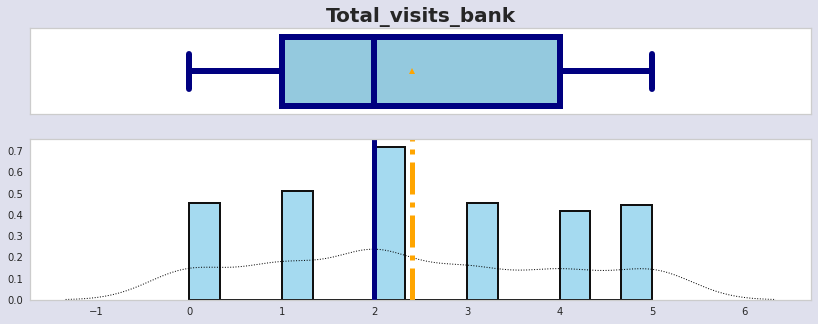

In [ ]:
histogram_boxplot(df['Total_visits_bank'])

- 15% of customers did NOT visit the bank
- 17% of customers have 1 visit to the bank
- 24% of customers have 2 visits to the bank
- 15% of customers have 3 visits to the bank
- 14% of customers have 4 visits to the bank
- 15% of customers have 5 visits to the bank

---

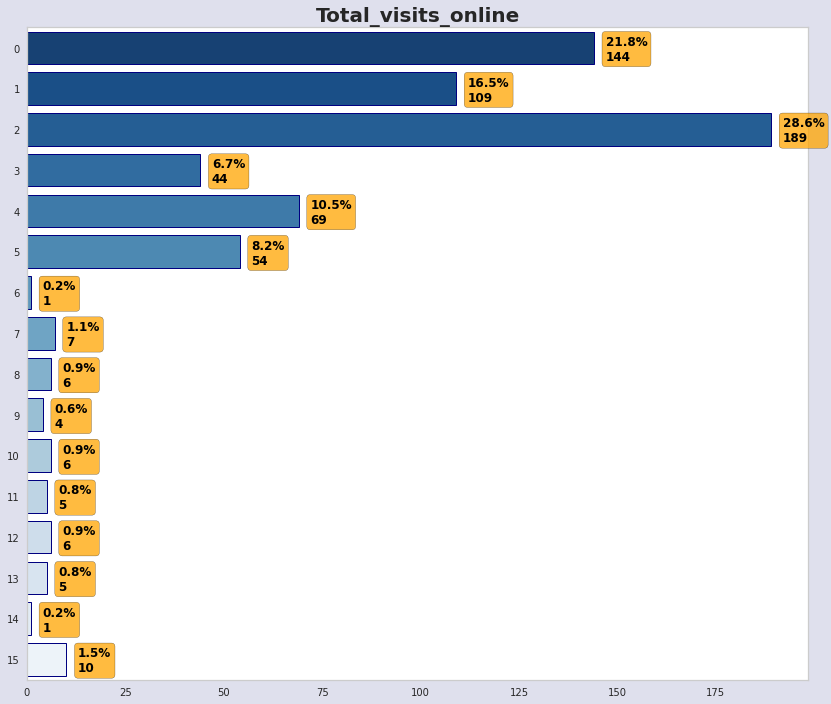

In [ ]:
bar_chart_bar('Total_visits_online', 12)

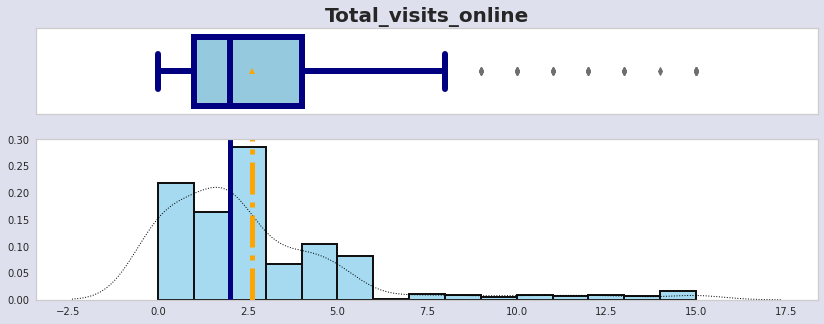

In [ ]:
histogram_boxplot(df['Total_visits_online'])

- 22% of customers did NOT have any online visits
- 17% of customers have 1 online visit
- 28% of customers have 2 online visits
- 7% of customers have 3 online visits
- 10% of customers have 4 online visits
- 8% of customers have 5 online visits
- 8% of total customers had 6 to 15 online visits

`Total_visits_online` has a few outliers above cap with a significant right skew. However, these do not appear to be errors. These appear to be a valid representation of the population. Therefore, these outliers will not be treated.

- Mean is 2.6
- Median is 2
- Significant right skewed distribution

---

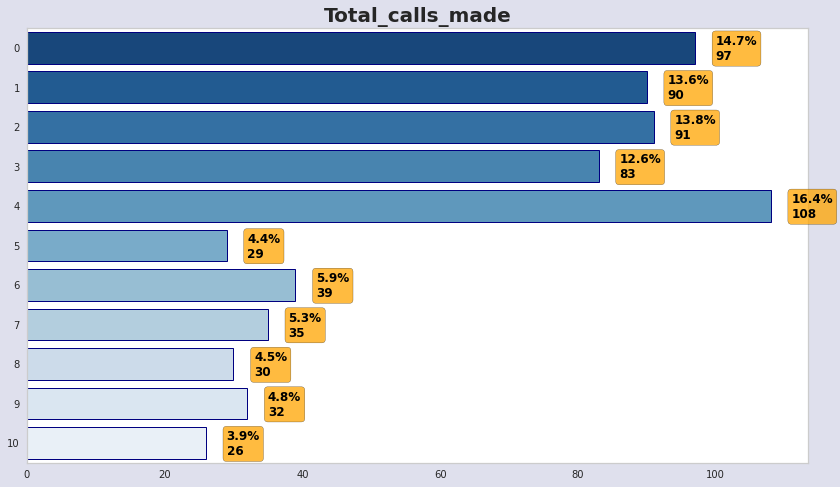

In [ ]:
bar_chart_bar('Total_calls_made', 8)

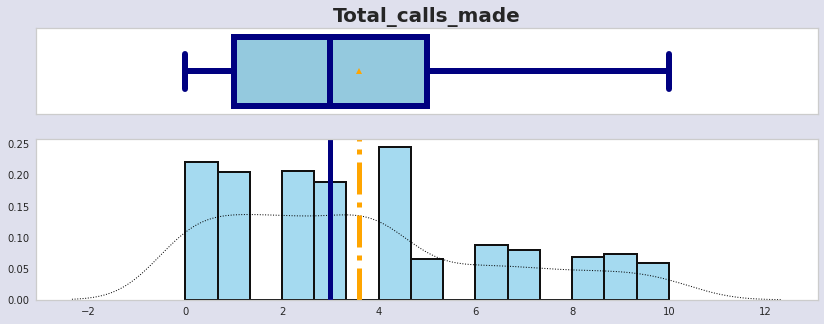

In [ ]:
histogram_boxplot(df['Total_calls_made'])

- 15% of customers did NOT make any calls
- 14% of customers have made 1 call
- 14% of customers have made 2 calls
- 12% of customers have made 3 calls
- 16% of customers have made 4 calls
- 4% of customers have made 5 calls
- 6% of customers have made 6 calls
- 5% of customers have made 7 calls
- 4% of customers have made 8 calls
- 5% of customers have made 9 calls
- 4% of customers have made 10 calls

---

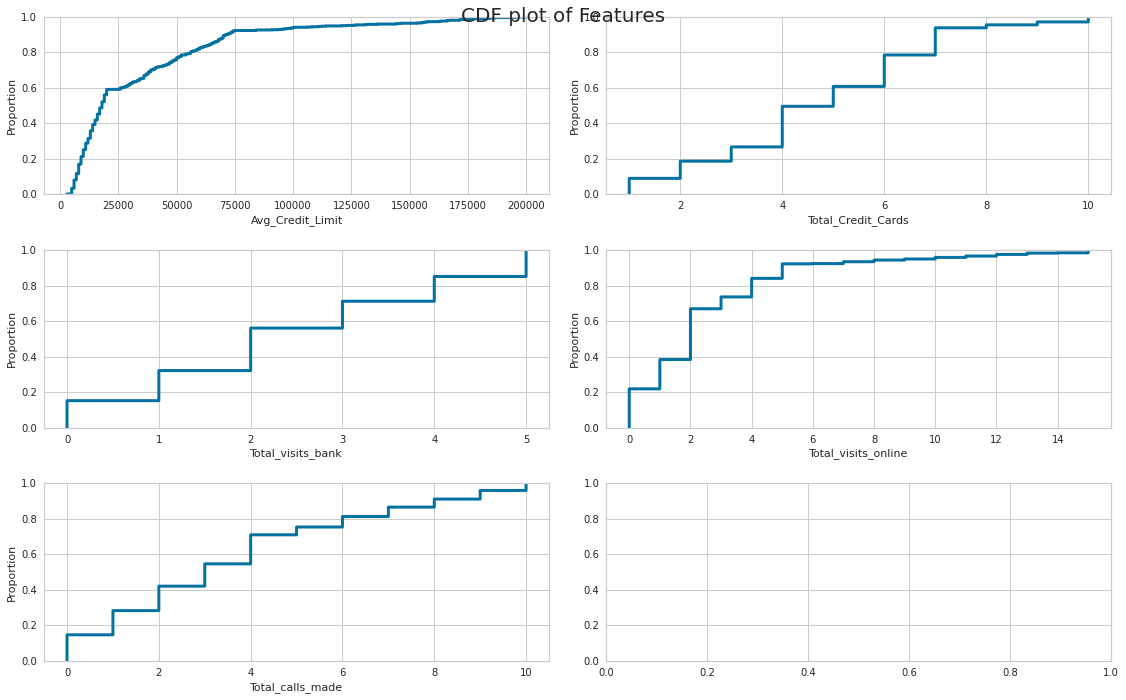

In [ ]:
# select numerical columns
all_col = df.select_dtypes(include=np.number).columns.tolist() #get list of column names to be used later for iterative functions

fig, axes = plt.subplots(3, 2,  figsize=(16, 10))
fig.suptitle('CDF plot of Features', fontsize=20)
counter = 0
for ii in range(3):
    sns.ecdfplot(ax=axes[ii][0],x=df[all_col[counter]],linewidth=3)
    counter = counter+1
    if counter != 5:
        sns.ecdfplot(ax=axes[ii][1],x=df[all_col[counter]],linewidth=3)
        counter = counter+1
    else:
        pass


fig.tight_layout(pad=2.0)

- 90% of customers have an AVG_Credit_Limit under `$75,000`
- 90% 0f customers have 5 or less visits online

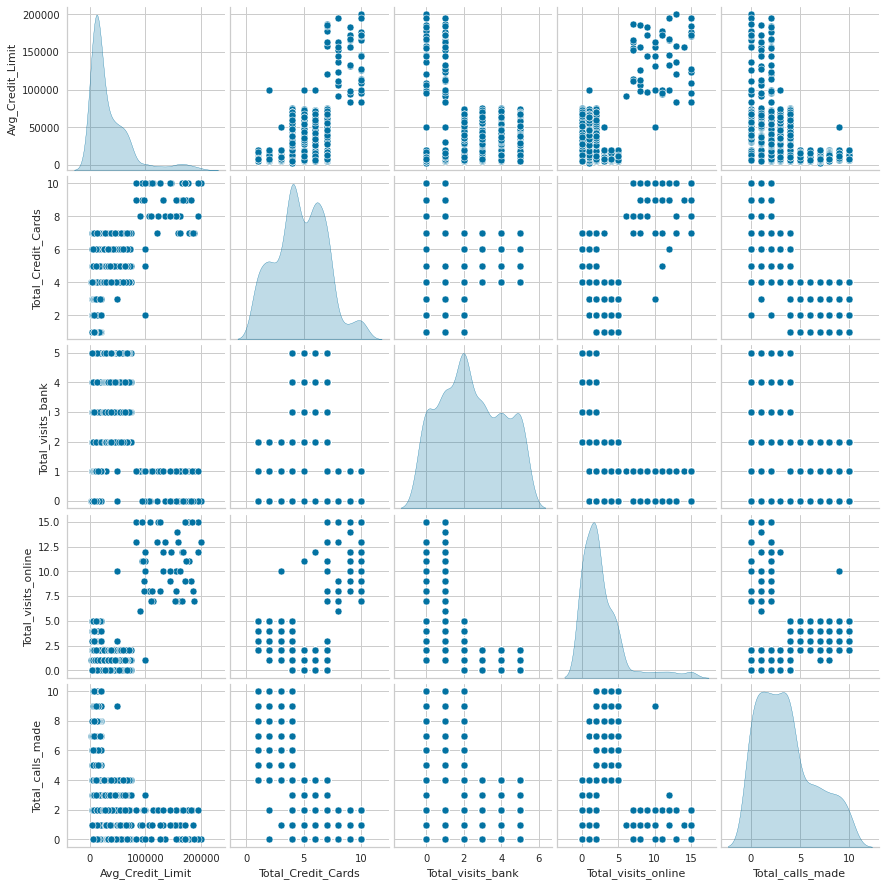

In [ ]:
sns.pairplot(df,diag_kind="kde");

- the KDE diagonals are not very clear but may indicate a minimum of 3 or 4 clusters

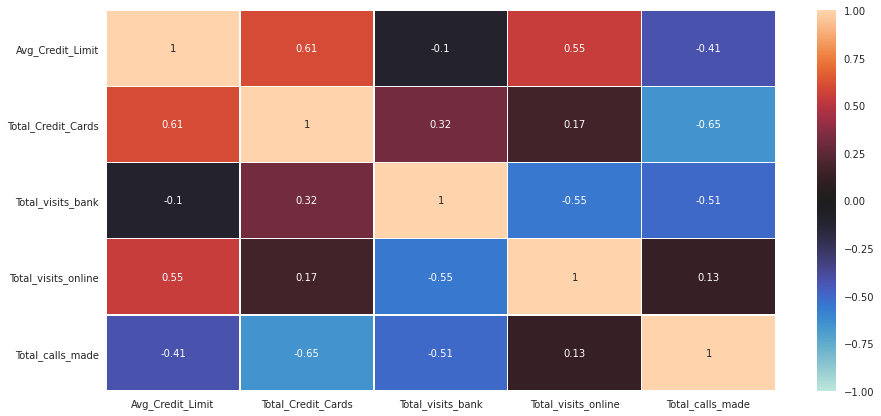

In [ ]:
plt.figure(figsize=(15,7))
sns.heatmap(df.corr(),annot=True,linewidths=0.5,vmin=-1,vmax=1,center=0,cbar=True);

- the heatmap shows some correlation among the variables.

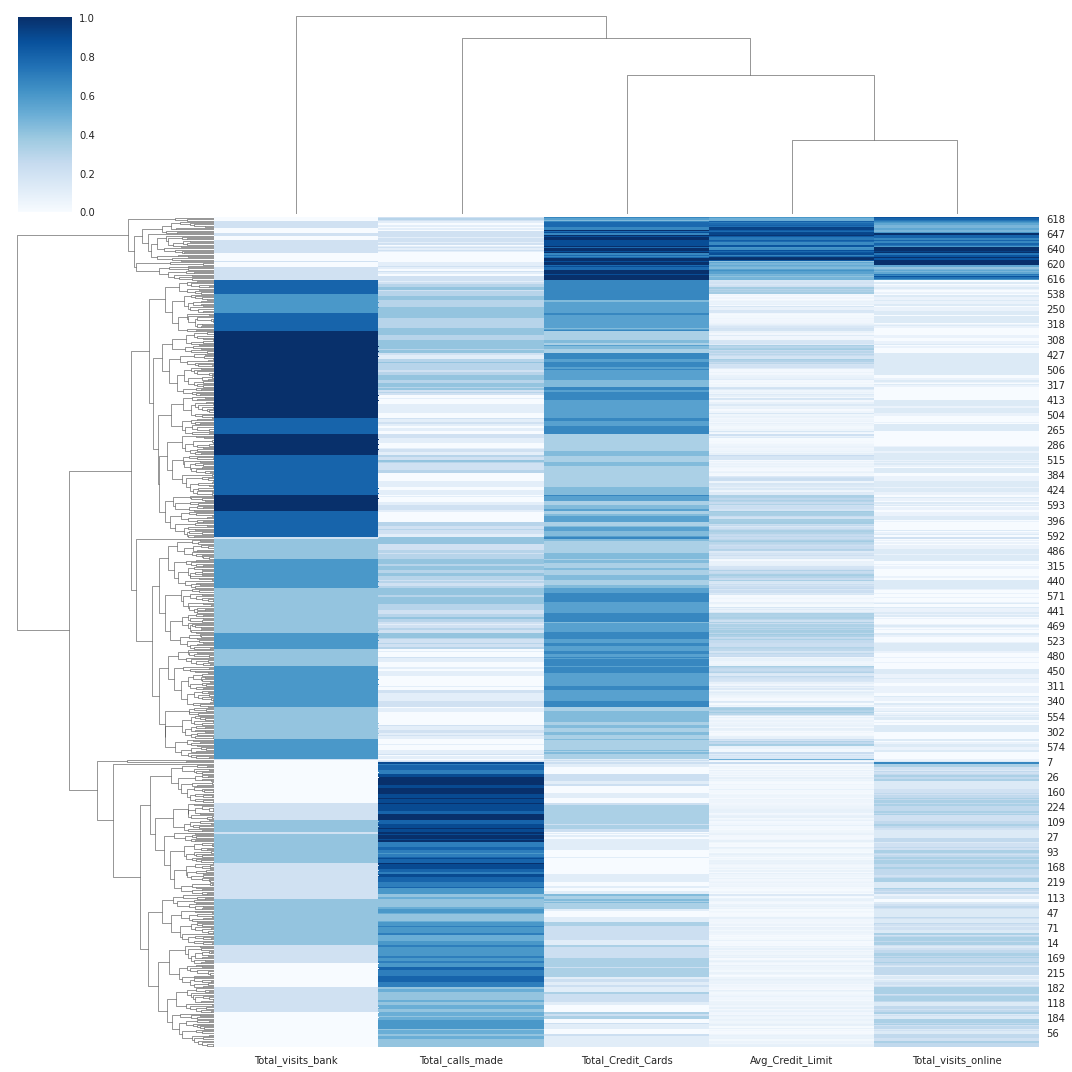

In [ ]:
sns.clustermap(df[all_col], figsize=(15, 15), cmap='Blues', standard_scale=1);

- The clustermap shows 3 clusters. 
- There is clustering in `Total_Visits_bank` near the top of the column.
- Another cluster is visible in `Total_calls_made` near the bottom of the column.
- a Third cluster is shown near the top of the columns for `Total_Credit_Cards`, `Avg_Credit_Limit`, `Total_visits_online`

# **Data pre-processing**



> ### **Outlier Treatment**



`Avg_Credit_Limit` has quite a few outliers above cap with a significant right skew. However, these do not appear to be errors. These appear to be a valid representation of the population. Therefore, these outliers will not be treated.
**`We will see in the cluster analysis below, that these outliers play a signigicant role in clustering which will help us understand the customer segmentation in a way that would be missed if these outliers were to be removed.`

`Total_visits_online` has a few outliers above cap with a significant right skew. However, these do not appear to be errors. These appear to be a valid representation of the population. Therefore, these outliers will not be treated.








> ### **Missing Value Treatment**



There are no missing values to impute



>  ### **Column Drops**



There are no features that have a strong enough correlation to warrant a column drop.
  - Let's confirm 

In [ ]:
# I found this handy snippet of code to use as a sanity check for high correlation on https://chrisalbon.com/machine_learning/feature_selection/drop_highly_correlated_features/
corr_matrix = df.corr().abs()
# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
to_drop

[]

- confirmed. No columns to drop.

> ### **Scaling**

In [ ]:
#scaling the data. put all columns on the same scale
sc = StandardScaler()
X_std = pd.DataFrame(sc.fit_transform(df),columns=df.columns)

In [ ]:
X_std.head()

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,1.740187,-1.249225,-0.860451,-0.547490,-1.251537
1,0.410293,-0.787585,-1.473731,2.520519,1.891859
2,0.410293,1.058973,-0.860451,0.134290,0.145528
3,-0.121665,0.135694,-0.860451,-0.547490,0.145528
4,1.740187,0.597334,-1.473731,3.202298,-0.203739


In [ ]:
X_std.describe()

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
count,6.600000e+02,6.600000e+02,6.600000e+02,6.600000e+02,6.600000e+02
mean,8.195465e-16,-4.006223e-15,1.157323e-16,1.944572e-16,-7.112156e-16
std,1.000758e+00,1.000758e+00,1.000758e+00,1.000758e+00,1.000758e+00
min,-8.398081e-01,-1.710864e+00,-1.473731e+00,-8.883795e-01,-1.251537e+00
25%,-6.536229e-01,-7.875852e-01,-8.604506e-01,-5.474897e-01,-9.022711e-01
50%,-4.408398e-01,1.356941e-01,-2.471705e-01,-2.065999e-01,-2.037386e-01
75%,3.570968e-01,5.973337e-01,9.793898e-01,4.751797e-01,4.947938e-01
max,4.399975e+00,2.443892e+00,1.592670e+00,4.224968e+00,2.241125e+00


In [ ]:
X_std.shape

(660, 5)

In [ ]:
#make a copy of the scaled dataset if needed
X_std_copy = X_std.copy()

# **K-means clustering**

Text(0.5, 1.0, 'Selecting k with the Elbow Method')

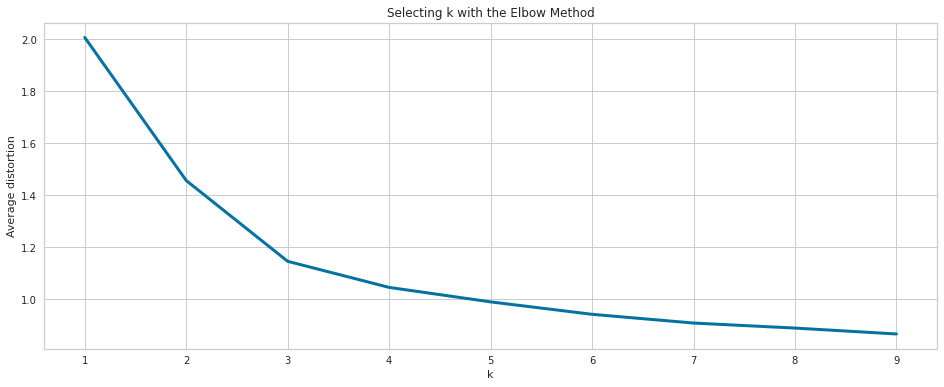

In [ ]:
from scipy.spatial.distance import cdist
clusters=range(1,10)
meanDistortions=[]

for k in clusters:
    model=KMeans(n_clusters=k)
    model.fit(X_std)
    prediction=model.predict(X_std)
    meanDistortions.append(sum(np.min(cdist(X_std, model.cluster_centers_, 'euclidean'), axis=1)) / X_std.shape[0])

plt.figure(figsize=(16, 6))
plt.plot(clusters, meanDistortions, 'bx-',linewidth=3)
plt.xlabel('k')
plt.ylabel('Average distortion')
plt.title('Selecting k with the Elbow Method')

- There is a clear elbow at 3 

For n_clusters = 2, silhouette score is 0.41842496663215445)



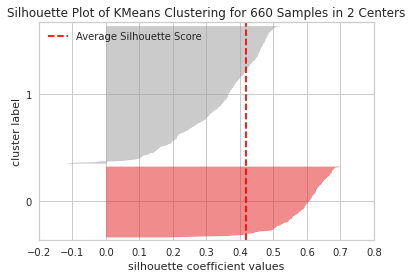

------------------------------------------------------------------

For n_clusters = 3, silhouette score is 0.5157182558881063)



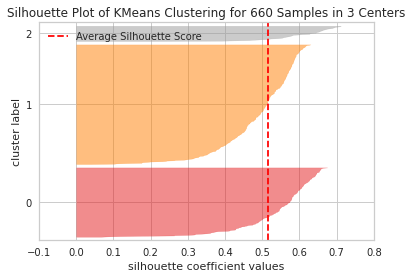

------------------------------------------------------------------

For n_clusters = 4, silhouette score is 0.3556670619372605)



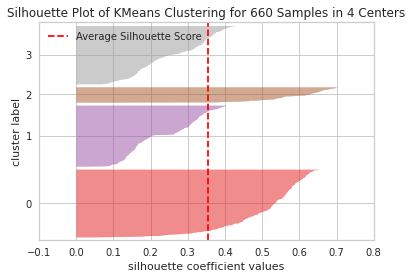

------------------------------------------------------------------

For n_clusters = 5, silhouette score is 0.2717470361089752)



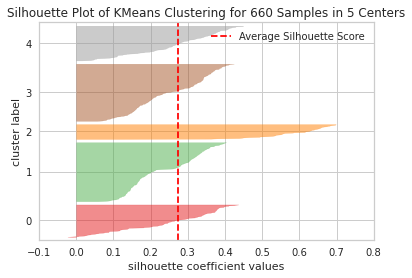

------------------------------------------------------------------

For n_clusters = 6, silhouette score is 0.255200197568894)



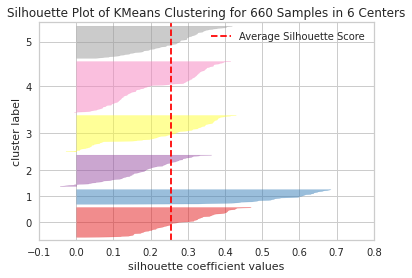

------------------------------------------------------------------

For n_clusters = 7, silhouette score is 0.2479482148219508)



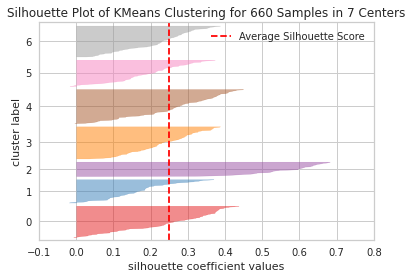

------------------------------------------------------------------

For n_clusters = 8, silhouette score is 0.22785450424250323)



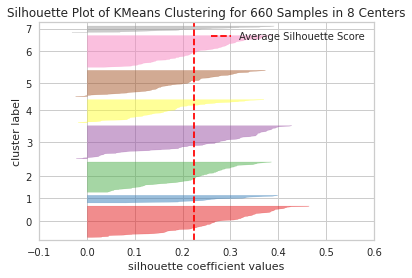

------------------------------------------------------------------

For n_clusters = 9, silhouette score is 0.22436784785391886)



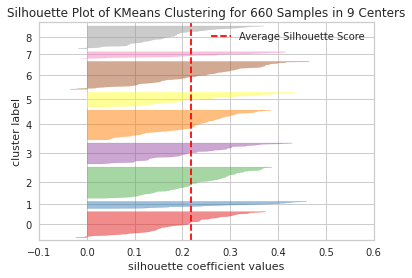

------------------------------------------------------------------



In [ ]:
#fig, axs = plt.subplots(8, 4, figsize=(15, 15))
sil_score = []
cluster_list = list(range(2,10))
for n_clusters in cluster_list:
    clusterer = KMeans(n_clusters=n_clusters)
    preds = clusterer.fit_predict((X_std))
    #centers = clusterer.cluster_centers_
    score = silhouette_score(X_std, preds)
    sil_score.append(score)
    print("For n_clusters = {}, silhouette score is {})".format(n_clusters, score))
    print()
    visualizer = SilhouetteVisualizer(KMeans(n_clusters, random_state = 1))
    visualizer.fit(X_std)    
    visualizer.show()
    print('------------------------------------------------------------------')
    print()

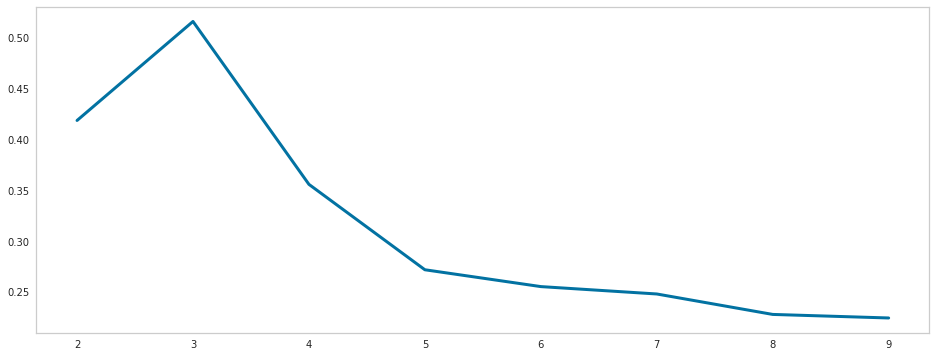

In [ ]:
plt.figure(figsize=(16, 6))
plt.plot(cluster_list,sil_score, linewidth=3)
plt.grid()

- Silhouette coefficient suggests 3 clusters are best. This also matches the observation made from the clustermap in the EDA section above.

***We will use 3 clusters based on the EDA and Silhouette coefficient shown above.***

In [ ]:
%%time
kmeans = KMeans(n_clusters=3, random_state=0)
kmeans.fit(X_std)

CPU times: user 48.2 ms, sys: 0 ns, total: 48.2 ms
Wall time: 51.1 ms


In [ ]:
#creating array for cluster algorithm comparisons
linkage_method = []
metrics = []
score = []

In [ ]:
linkage_method.append('kmeans')
metrics.append('euclidean')
score.append(silhouette_score(X_std, kmeans.labels_))
silhouette_score(X_std, kmeans.labels_)

0.5157182558881063

In [ ]:
df['K_means_segments'] = kmeans.labels_

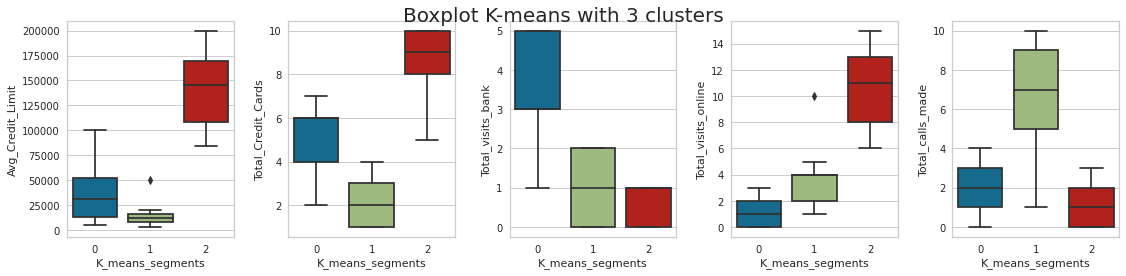

In [ ]:
  fig, axes = plt.subplots(1, 5,  figsize=(16, 4))
  fig.suptitle('Boxplot K-means with 3 clusters', fontsize=20)
  counter = 0
  for ii in range(5):
      sns.boxplot(ax=axes[ii],y=df[all_col[counter]],x=df['K_means_segments'])
      counter = counter+1

  fig.tight_layout(pad=2.0)
  plt.show()

K-means has generated 3 clusters. We'll interpret this in the cluster profiling section below.

# **Hierarchical clustering**

### **linkage matrix**

In [ ]:
#Lets explore 'centroid', 'median','ward' linkage method which requires only Euclidean distance metrics
# cophenet index is a measure of the correlation between the distance of points in feature space and distance on dendrogram
distance_metrics = [ 'euclidean','chebyshev','mahalanobis','cityblock']
linkage_methods = ['single', 'complete', 'average', 'weighted', 'median', 'centroid', 'ward']
high_cophenet_corr = 0
high_dm_lm = [0,0]
for lm in linkage_methods:
  print (' --------- ' + str(lm.upper()) + ' --------- ')
  if lm in ['median', 'centroid', 'ward']:
    #print(' --euclidean')
    Z = linkage(X_std, metric='euclidean', method=lm)
    c, coph_dists = cophenet(Z , pdist(X_std))
    print('Cophenetic correlation where distance metric = {} and linkage method {} is {}'.format('Euclidean',lm.capitalize(),c))
  else:
    for dm in distance_metrics:
      #print(' --' + str(dm))
      Z = linkage(X_std, metric=dm, method=lm)
      c, coph_dists = cophenet(Z , pdist(X_std))
      print('Cophenetic correlation for distance metric = {} and linkage method {} is {}'.format(dm.capitalize(),lm.capitalize(),c))
      if high_cophenet_corr < c:
        high_cophenet_corr = c
        high_dm_lm[0] = dm
        high_dm_lm[1] = lm
  print()



 --------- SINGLE --------- 
Cophenetic correlation for distance metric = Euclidean and linkage method Single is 0.7391220243806552
Cophenetic correlation for distance metric = Chebyshev and linkage method Single is 0.7382354769296767
Cophenetic correlation for distance metric = Mahalanobis and linkage method Single is 0.7058064784553605
Cophenetic correlation for distance metric = Cityblock and linkage method Single is 0.7252379350252722

 --------- COMPLETE --------- 
Cophenetic correlation for distance metric = Euclidean and linkage method Complete is 0.8599730607972423
Cophenetic correlation for distance metric = Chebyshev and linkage method Complete is 0.8533474836336782
Cophenetic correlation for distance metric = Mahalanobis and linkage method Complete is 0.5422791209801748
Cophenetic correlation for distance metric = Cityblock and linkage method Complete is 0.8731477899179829

 --------- AVERAGE --------- 
Cophenetic correlation for distance metric = Euclidean and linkage metho

In [ ]:
print('Highest cophenetic correlation is {}, which is obtinaed with {} distance metric and {} linkage method'.format(high_cophenet_corr ,high_dm_lm[0].capitalize(),high_dm_lm[1].capitalize()))

Highest cophenetic correlation is 0.8977080867389372, which is obtinaed with Euclidean distance metric and Average linkage method


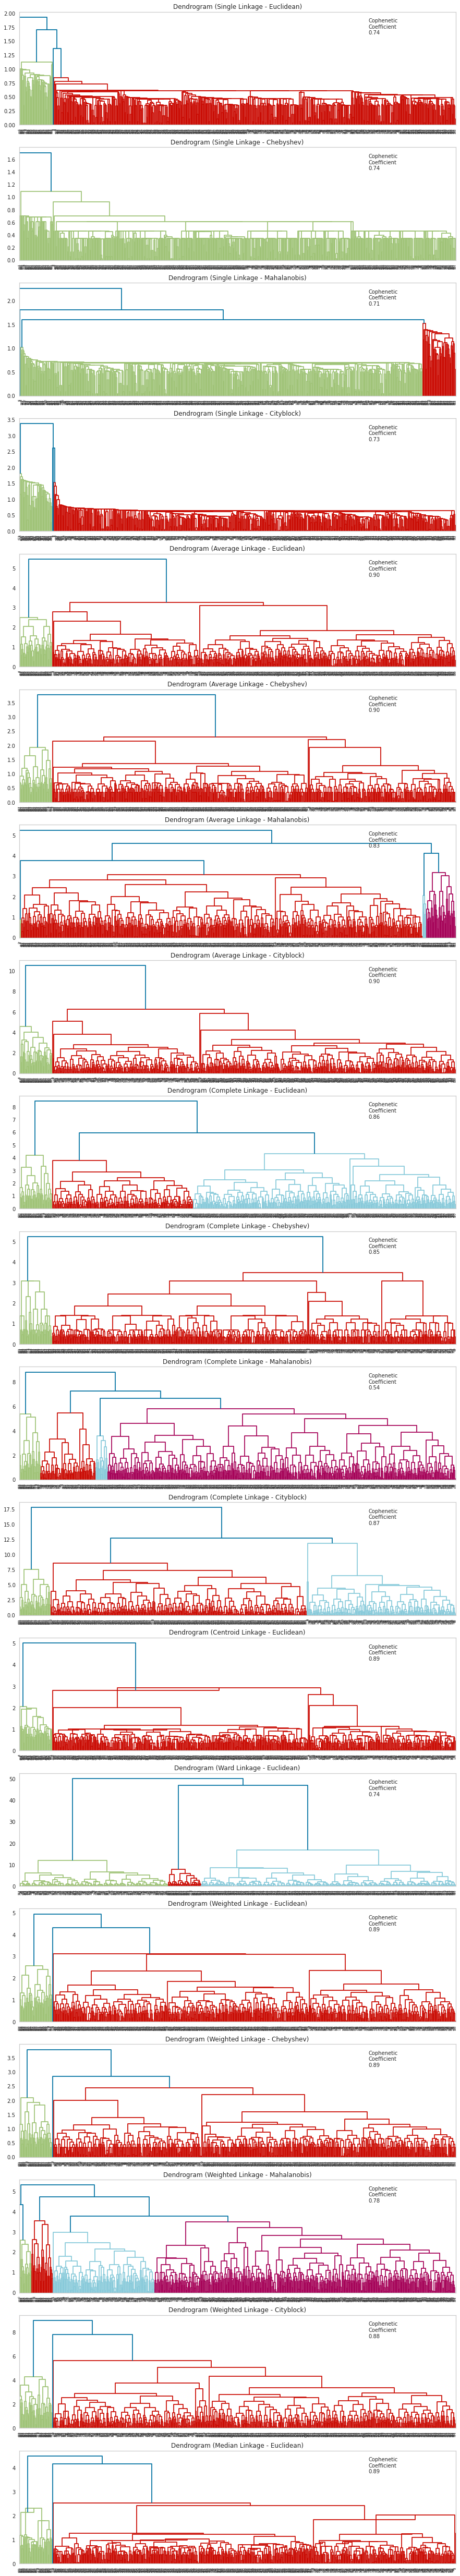

In [ ]:

# List of all linkage methods to check
methods = ['single','average','complete','centroid','ward','weighted','median']
metrics = ['euclidean','chebyshev','mahalanobis','cityblock']


# Create lists to save results of coph calculation
compare_cols = ['Linkage', 'Cophenetic Coefficient']
compare = []

# Create a subplot image
fig, axs = plt.subplots(19, 1, figsize=(15, 90))

i=0
for lm in methods:
  #print (' --------- ' + str(lm.upper()) + ' --------- ')
  if lm in ['median', 'centroid', 'ward']:
    #print(' --euclidean')
    Z = linkage(X_std, metric='euclidean', method=lm)

    dendrogram(Z, ax=axs[i]);
    axs[i].set_title(f'Dendrogram ({lm.capitalize()} Linkage - Euclidean)')
    coph_corr, coph_dist = cophenet(Z, pdist(X_std))
    axs[i].annotate(f'Cophenetic\nCoefficient\n{coph_corr:0.2f}', 
                    (0.80, 0.80),
                    xycoords='axes fraction')
    #compare.append([lm, coph_corr])
    axs[i].grid(False)
    i +=1
  else:
    for dm in metrics:
      #print(' --euclidean')
      Z = linkage(X_std, metric=dm, method=lm)

      dendrogram(Z, ax=axs[i]);
      axs[i].set_title(f'Dendrogram ({lm.capitalize()} Linkage - {dm.capitalize()})')
      coph_corr, coph_dist = cophenet(Z, pdist(X_std))
      axs[i].annotate(f'Cophenetic\nCoefficient\n{coph_corr:0.2f}', 
                      (0.80, 0.80),
                      xycoords='axes fraction')
      axs[i].grid(False)
      i +=1
  compare.append([lm, coph_corr])


- **Ward Linkage with Euclidean Distance** appears to be the best Dendrogram based on clear, even segmentation and uniform dendromatic distances. However, it doesn't have the highest Cophenetic Coefficient

- **Complete Linkage with CityBlock Distance** may be a good second option. It has a higher Cophenetic Coefficient. The dendrogram for this has clear segmentation - but not as clear as Ward/Euclidean

- **Average Linkage with Euclidean Distance** has the highest Cophenetic Correlation but the dendrogram doesn't look well. Therefore, we will not be using Average/Euclidean

### **3 clusters**

Ward/Euclidean

In [ ]:
#create model with 3 clusters
model = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='ward')
model.fit(X_std)
df['labels_ward'] = model.labels_
linkage_method.append('ward')
metrics.append('euclidean')
score.append(silhouette_score(X_std, model.labels_))
silhouette_score(X_std, model.labels_)

0.5147639589977819

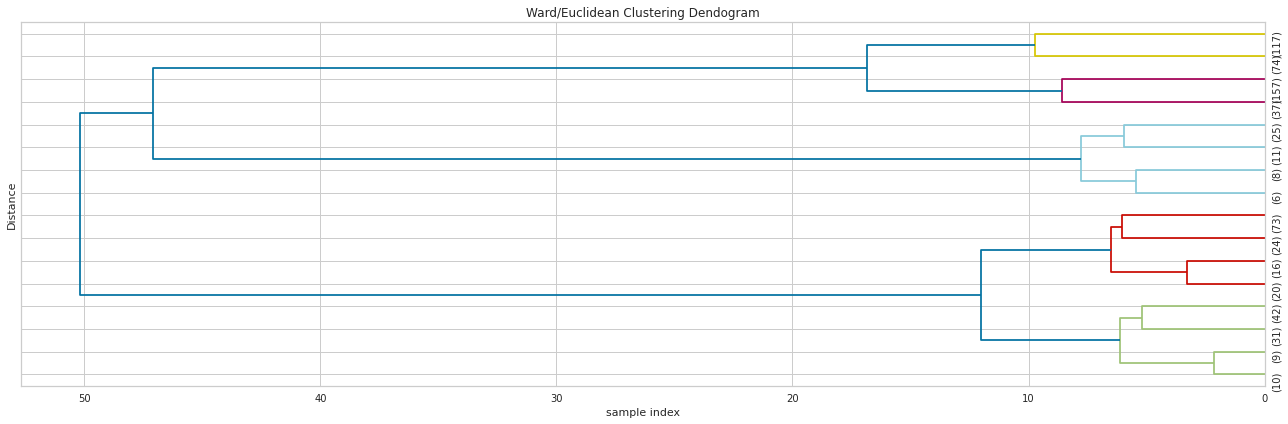

In [ ]:
plt.figure(figsize=(18, 6))
plt.title('Ward/Euclidean Clustering Dendogram')
plt.xlabel('sample index')
plt.ylabel('Distance')
dendrogram(linkage(X_std, 'ward',metric='euclidean'), leaf_rotation=90.0, p=3,
           color_threshold=10, leaf_font_size=10, truncate_mode='level', orientation='left')

plt.tight_layout()

- Ward/Euclidean Clustering has a silhoutte score of 51
- Truncated dendrogram is shown above

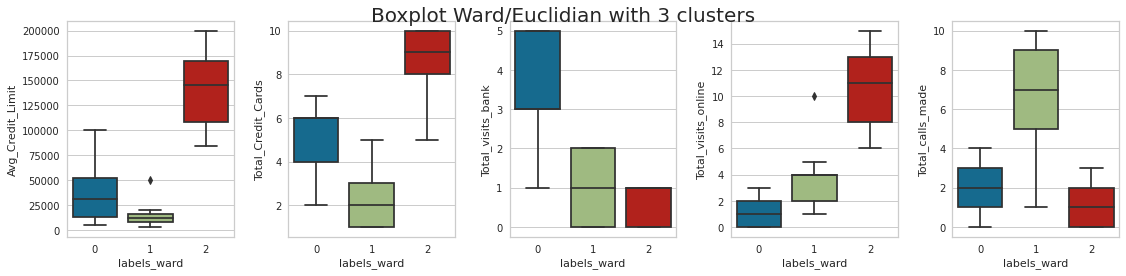

In [ ]:
  fig, axes = plt.subplots(1, 5,  figsize=(16, 4))
  fig.suptitle('Boxplot Ward/Euclidian with 3 clusters', fontsize=20)
  counter = 0
  for ii in range(5):
      sns.boxplot(ax=axes[ii],y=df[all_col[counter]],x=df['labels_ward'])
      counter = counter+1

  fig.tight_layout(pad=2.0)
  plt.show()

Ward/Euclidian with 3 clusters. We'll interpret this in the cluster profiling section below.

Complete/CityBlock

In [ ]:
model = AgglomerativeClustering(n_clusters=3, affinity='cityblock', linkage='complete')
model.fit(X_std)
df['labels_complete'] = model.labels_
linkage_method.append('complete')
metrics.append('cityblock')
score.append(silhouette_score(X_std, model.labels_))
silhouette_score(X_std, model.labels_)

0.5122288438783027

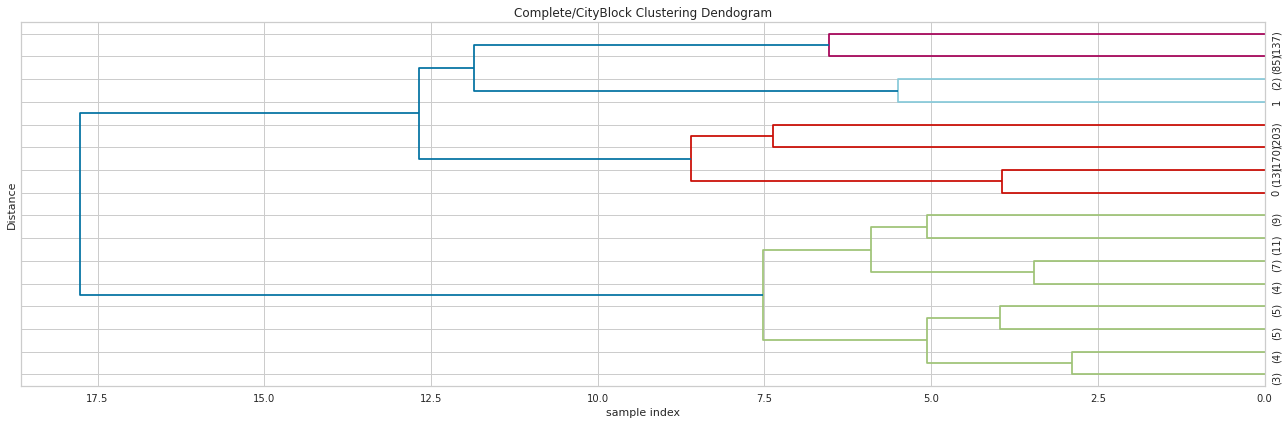

In [ ]:
plt.figure(figsize=(18, 6))
plt.title('Complete/CityBlock Clustering Dendogram')
plt.xlabel('sample index')
plt.ylabel('Distance')
dendrogram(linkage(X_std, 'complete',metric='cityblock'), leaf_rotation=90.0, p=3,
           color_threshold=10, leaf_font_size=10, truncate_mode='level', orientation='left')
plt.tight_layout()

- Complete/CityBlock Clustering has a silhoutte score of 51
- Truncated dendrogram is shown above

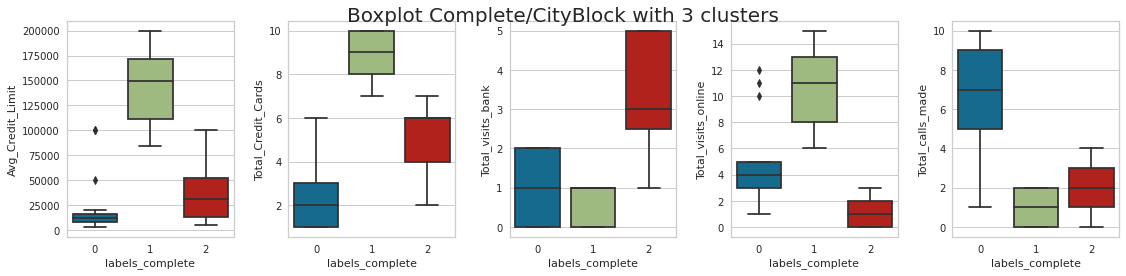

In [ ]:
  fig, axes = plt.subplots(1, 5,  figsize=(16, 4))
  fig.suptitle('Boxplot Complete/CityBlock with 3 clusters', fontsize=20)
  counter = 0
  for ii in range(5):
      sns.boxplot(ax=axes[ii],y=df[all_col[counter]],x=df['labels_complete'])
      counter = counter+1

  fig.tight_layout(pad=2.0)
  plt.show()

Complete/CityBlock with 3 clusters. We'll interpret this in the cluster profiling section below.

# **Cluster Comparison: K-means and Hierarchical Profiling**

We will compare our Hierarchical (Ward/Euclidian) vs K-means models.
I'm also including a Hierarchical (Complete/CityBlock) for additional comparison

#### *- cluster value counts -*

In [ ]:
df['K_means_segments'].value_counts()

0    386
1    224
2     50
Name: K_means_segments, dtype: int64

In [ ]:
df['labels_ward'].value_counts()

0    385
1    225
2     50
Name: labels_ward, dtype: int64

In [ ]:
df['labels_complete'].value_counts()

2    387
0    225
1     48
Name: labels_complete, dtype: int64

In [ ]:
df['labels_ward'].value_counts(normalize=True)

0    0.583333
1    0.340909
2    0.075758
Name: labels_ward, dtype: float64

    **OBSERVATIONS:
      - 3 clusters generate consistent numbers between the 3 models generated
      - Cluster 0 makes up 58% of the dataset
      - Cluster 1 makes up 34% of the dataset
      - Cluster 2 makes up 8% of the dataset
      - Ward/Euclidean and Complete/CityBlock have different labeling

K-Means and Ward/Euclidean are VERY similar. Let's explore.

In [ ]:
df.loc[(df['K_means_segments'] == 2) & (df['labels_ward'] == 2)].value_counts().sum()

50

In [ ]:
df.loc[(df['K_means_segments'] == 1) & (df['labels_ward'] == 1)].value_counts().sum()

224

In [ ]:
df.loc[df['K_means_segments'] != df['labels_ward']]

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,K_means_segments,labels_ward,labels_complete
288,7000,5,2,2,4,0,1,2


    **OBSERVATION:
      - There is only one non-matching value between Ward/Euclidean and K-means.

The label assignments for Complete/CityBlock don't match Ward/Euclidean although they are primarily the same. Let's correct that so that Boxplot comparison is easier to interpret.

In [ ]:
df.replace({'labels_complete': {1: 2, 2: 0, 0: 1}}, inplace=True)

#### *- cluster means -*

In [ ]:
cluster_profile_K_means = df.groupby('K_means_segments').mean()
cluster_profile_K_means.style.highlight_max(color = 'green', axis = 0)

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,labels_ward,labels_complete
K_means_segments,,,,,,,
0,33782.383420,5.515544,3.489637,0.981865,2.000000,0.002591,0.000000
1,12174.107143,2.410714,0.933036,3.553571,6.870536,1.000000,0.995536
2,141040.000000,8.740000,0.600000,10.900000,1.080000,2.000000,1.960000


In [ ]:
cluster_profile_ward = df.groupby('labels_ward').mean()
cluster_profile_ward.style.highlight_max(color = 'green', axis = 0)

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,K_means_segments,labels_complete
labels_ward,,,,,,,
0,33851.948052,5.516883,3.493506,0.979221,1.994805,0.000000,0.000000
1,12151.111111,2.422222,0.937778,3.546667,6.857778,0.995556,0.991111
2,141040.000000,8.740000,0.600000,10.900000,1.080000,2.000000,1.960000


In [ ]:
cluster_profile_complete = df.groupby('labels_complete').mean()
cluster_profile_complete.style.highlight_max(color = 'green', axis = 0)


,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,K_means_segments,labels_ward
labels_complete,,,,,,,
0,33713.178295,5.511628,3.485788,0.984496,2.005168,0.002584,0.005168
1,12977.777778,2.431111,0.920000,3.631111,6.844444,1.008889,1.008889
2,142750.000000,8.875000,0.625000,10.875000,1.020833,2.000000,2.000000


All 3 models are VERY similar. Only one or two variations per model with 3 clusters chosen.

#### *- cluster boxplots -*

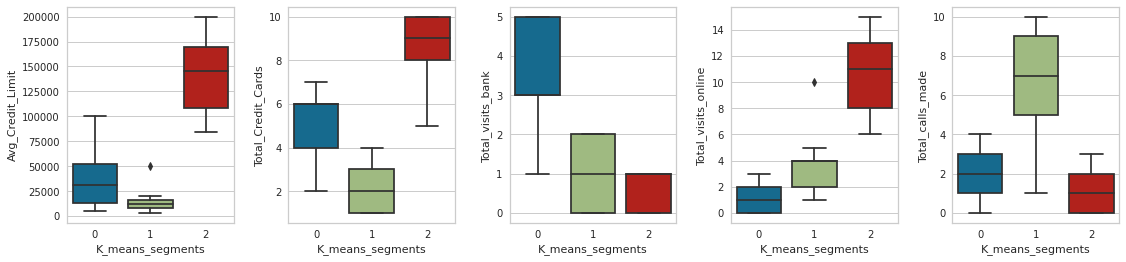

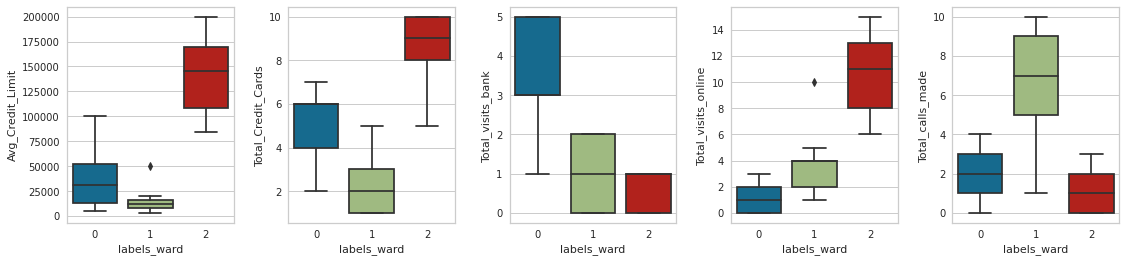

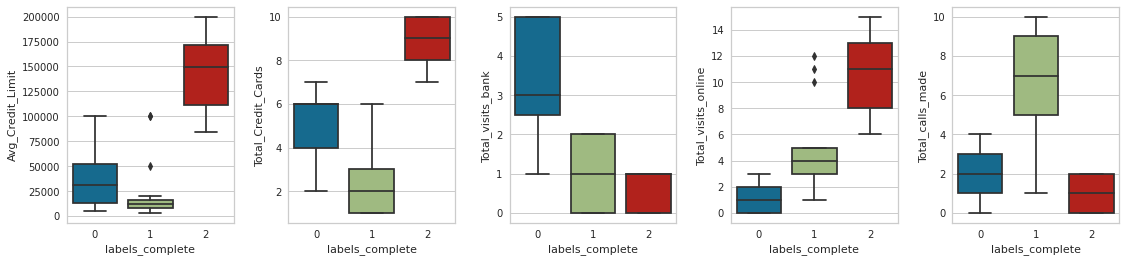

In [ ]:
cluster_labels = ['K_means_segments','labels_ward','labels_complete']

for c in cluster_labels:
  fig, axes = plt.subplots(1, 5,  figsize=(16, 4))

  counter = 0
  for ii in range(5):
      sns.boxplot(ax=axes[ii],y=df[all_col[counter]],x=df[c])
      counter = counter+1

  fig.tight_layout(pad=2.0)
  plt.show()

Viewing boxplots for all 3 models. All three are very simlar with just one individual different customer assignment between K-Means and Ward/Euclidean.
There are only 2 different customer assignments between Ward/Euclidean and Complete CityBlock. Complete/CityBlock creates more variance with the cluster boxplots and produces more outliers in the segment boxplots. I will choose Ward/Euclidean as our Model

### Cluster 0 - `Average_Credit_Limit`

In [ ]:
df.Avg_Credit_Limit[df['labels_ward'] == 0].describe() #feature summary for this cluster

count       385.000000
mean      33851.948052
std       22156.084628
min        5000.000000
25%       13000.000000
50%       31000.000000
75%       52000.000000
max      100000.000000
Name: Avg_Credit_Limit, dtype: float64

This cluster contains customers with an average credit limit between `$5,000` and `$100,000`. Median of `$31,000`

### Cluster 1 - `Average_Credit_Limit`

In [ ]:
df.Avg_Credit_Limit[df['labels_ward'] == 1].describe() #feature summary for this cluster

count      225.000000
mean     12151.111111
std       5248.665741
min       3000.000000
25%       8000.000000
50%      12000.000000
75%      16000.000000
max      50000.000000
Name: Avg_Credit_Limit, dtype: float64

- This cluster contains customers with an average credit limit between `$3,000` and `$50,000`. Median of `$12,000`

### Cluster 2 - `Average_Credit_Limit`

In [ ]:
df.Avg_Credit_Limit[df['labels_ward'] == 2].describe() #feature summary for this cluster

count        50.000000
mean     141040.000000
std       34457.877272
min       84000.000000
25%      108750.000000
50%      145500.000000
75%      170000.000000
max      200000.000000
Name: Avg_Credit_Limit, dtype: float64

- This cluster contains customers with an average credit limit between `$84,000` and `$200,000`. Median of `$145,500`



---



### Cluster 0 - `Total_Credit_Cards`

In [ ]:
df.Total_Credit_Cards[df['labels_ward'] == 0].describe() #feature summary for this cluster

count    385.000000
mean       5.516883
std        1.141249
min        2.000000
25%        4.000000
50%        6.000000
75%        6.000000
max        7.000000
Name: Total_Credit_Cards, dtype: float64

In [ ]:
df.Total_Credit_Cards[df['labels_ward'] == 0].value_counts(normalize=True) #show percentage breakdown

6    0.301299
4    0.264935
7    0.244156
5    0.187013
2    0.002597
Name: Total_Credit_Cards, dtype: float64

   - Customers in this group primarily have 4 to 7 credit cards. Less than 1% of customers in this group have only 2 credit cards.

### Cluster 1 - `Total_Credit_Cards`

In [ ]:
df.Total_Credit_Cards[df['labels_ward'] == 1].describe() #feature summary for this cluster

count    225.000000
mean       2.422222
std        1.111805
min        1.000000
25%        1.000000
50%        2.000000
75%        3.000000
max        5.000000
Name: Total_Credit_Cards, dtype: float64

In [ ]:
df.Total_Credit_Cards[df['labels_ward'] == 1].value_counts(normalize=True) #show percentage breakdown

2    0.280000
1    0.262222
3    0.235556
4    0.217778
5    0.004444
Name: Total_Credit_Cards, dtype: float64

- Customers in this group primarily have 1 to 4 credit cards. Less than 1% of customers in this group have 5 credit cards.

### Cluster 2 - `Total_Credit_Cards`

In [ ]:
df.Total_Credit_Cards[df['labels_ward'] == 2].describe() #feature summary for this cluster

count    50.000000
mean      8.740000
std       1.274715
min       5.000000
25%       8.000000
50%       9.000000
75%      10.000000
max      10.000000
Name: Total_Credit_Cards, dtype: float64

In [ ]:
df.Total_Credit_Cards[df['labels_ward'] == 2].value_counts(normalize=True) #show percentage breakdown

10    0.38
9     0.22
8     0.22
7     0.14
6     0.02
5     0.02
Name: Total_Credit_Cards, dtype: float64

- Customers in this group primarily have 7 to 10 credit cards. 2% of customers in this group have 5 credit cards. 2% of customers in this group have 6 credit cards.



---



### Cluster 0 - `Total_visits_bank`

In [ ]:
df.Total_visits_bank[df['labels_ward'] == 0].describe() #feature summary for this cluster

count    385.000000
mean       3.493506
std        1.134490
min        1.000000
25%        3.000000
50%        3.000000
75%        5.000000
max        5.000000
Name: Total_visits_bank, dtype: float64

In [ ]:
df.Total_visits_bank[df['labels_ward'] == 0].value_counts(normalize=True) #show percentage breakdown

3    0.259740
5    0.254545
4    0.238961
2    0.238961
1    0.007792
Name: Total_visits_bank, dtype: float64

- Visits to the bank in this group primarily range from 2 to 5 visits. Less than 1% of customers in this group had only 1 visit to the bank.

### Cluster 1 - `Total_visits_bank`

In [ ]:
df.Total_visits_bank[df['labels_ward'] == 1].describe() #feature summary for this cluster

count    225.000000
mean       0.937778
std        0.804920
min        0.000000
25%        0.000000
50%        1.000000
75%        2.000000
max        2.000000
Name: Total_visits_bank, dtype: float64

In [ ]:
df.Total_visits_bank[df['labels_ward'] == 1].value_counts(normalize=True) #show percentage breakdown

0    0.355556
1    0.351111
2    0.293333
Name: Total_visits_bank, dtype: float64

- Visits to the bank in this group range from 0 to 2 visits.

### Cluster 2 - `Total_visits_bank`

In [ ]:
df.Total_visits_bank[df['labels_ward'] == 2].describe() #feature summary for this cluster

count    50.000000
mean      0.600000
std       0.494872
min       0.000000
25%       0.000000
50%       1.000000
75%       1.000000
max       1.000000
Name: Total_visits_bank, dtype: float64

In [ ]:
df.Total_visits_bank[df['labels_ward'] == 2].value_counts(normalize=True) #show percentage breakdown

1    0.6
0    0.4
Name: Total_visits_bank, dtype: float64

- Visits to the bank in this group range from 0 to 1 visit.



---



### Cluster 0 - `Total_visits_online`

In [ ]:
df.Total_visits_online[df['labels_ward'] == 0].describe() #feature summary for this cluster

count    385.000000
mean       0.979221
std        0.856704
min        0.000000
25%        0.000000
50%        1.000000
75%        2.000000
max        3.000000
Name: Total_visits_online, dtype: float64

In [ ]:
df.Total_visits_online[df['labels_ward'] == 0].value_counts(normalize=True) #show percentage breakdown

0    0.374026
2    0.348052
1    0.275325
3    0.002597
Name: Total_visits_online, dtype: float64

- Online Visits in this group primarily range from 0 to 2. Less than 1% of customers in this group had 3 online visits.

### Cluster 1 - `Total_visits_online`

In [ ]:
df.Total_visits_online[df['labels_ward'] == 1].describe() #feature summary for this cluster

count    225.000000
mean       3.546667
std        1.220656
min        1.000000
25%        2.000000
50%        4.000000
75%        4.000000
max       10.000000
Name: Total_visits_online, dtype: float64

In [ ]:
df.Total_visits_online[df['labels_ward'] == 1].value_counts(normalize=True) #show percentage breakdown

4     0.306667
2     0.244444
5     0.240000
3     0.191111
1     0.013333
10    0.004444
Name: Total_visits_online, dtype: float64

- Online Visits in this group primarily range from 3 to 5. One percent of customers in this group had 1 online visit. Less than 1% of customers in this group had 10 online visits.

### Cluster 2 - `Total_visits_online`

In [ ]:
df.Total_visits_online[df['labels_ward'] == 2].describe() #feature summary for this cluster

count    50.000000
mean     10.900000
std       2.880264
min       6.000000
25%       8.000000
50%      11.000000
75%      13.000000
max      15.000000
Name: Total_visits_online, dtype: float64

In [ ]:
df.Total_visits_online[df['labels_ward'] == 2].value_counts(normalize=True) #show percentage breakdown

15    0.20
7     0.14
12    0.12
8     0.12
13    0.10
11    0.10
10    0.10
9     0.08
14    0.02
6     0.02
Name: Total_visits_online, dtype: float64

Online Visits in this group primarily range from 7 to 15. Two percent of customers in this group had 6 online visits.



---



### Cluster 0 - `Total_calls_made`

In [ ]:
df.Total_calls_made[df['labels_ward'] == 0].describe() #feature summary for this cluster

count    385.000000
mean       1.994805
std        1.428860
min        0.000000
25%        1.000000
50%        2.000000
75%        3.000000
max        4.000000
Name: Total_calls_made, dtype: float64

In [ ]:
df.Total_calls_made[df['labels_ward'] == 0].value_counts(normalize=True) #show percentage breakdown

3    0.212987
0    0.210390
4    0.197403
1    0.192208
2    0.187013
Name: Total_calls_made, dtype: float64

- Customers in this group made 0 to 4 calls.

### Cluster 1 - `Total_calls_made`

In [ ]:
df.Total_calls_made[df['labels_ward'] == 1].describe() #feature summary for this cluster

count    225.000000
mean       6.857778
std        1.994914
min        1.000000
25%        5.000000
50%        7.000000
75%        9.000000
max       10.000000
Name: Total_calls_made, dtype: float64

In [ ]:
df.Total_calls_made[df['labels_ward'] == 1].value_counts(normalize=True) #show percentage breakdown

6     0.173333
7     0.155556
9     0.142222
4     0.142222
8     0.133333
5     0.128889
10    0.115556
2     0.004444
1     0.004444
Name: Total_calls_made, dtype: float64

Customers in this group primarily made 4 to 10 calls. Less than 1% of customers in this group made 1 to 2 calls.

### Cluster 2 - `Total_calls_made`

In [ ]:
df.Total_calls_made[df['labels_ward'] == 2].describe() #feature summary for this cluster

count    50.000000
mean      1.080000
std       0.876915
min       0.000000
25%       0.000000
50%       1.000000
75%       2.000000
max       3.000000
Name: Total_calls_made, dtype: float64

In [ ]:
df.Total_calls_made[df['labels_ward'] == 2].value_counts(normalize=True) #show percentage breakdown

2    0.36
0    0.32
1    0.30
3    0.02
Name: Total_calls_made, dtype: float64

Customers in this group primarily made 0 to 2 calls. 2% of customers in this group made 3 calls.

### Scatter Comparison using Ordinal vs Continuous features

[]

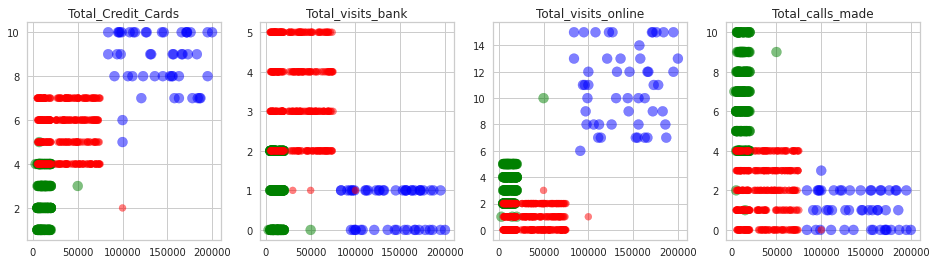

In [ ]:
fig, axes = plt.subplots(1, 4,  figsize=(16, 4))
counter = 0
for ii in range(4):
  df["val"] = df['labels_ward'].apply(lambda x: "red" if x==0 else ("green" if x==1 else "blue"))

  not_red_df = df.loc[df['val'] != 'red']
  red_df = df.loc[df['val'] == 'red']
  
  axes[ii].scatter(x=not_red_df["Avg_Credit_Limit"], y=not_red_df[all_col[counter+1]], c=not_red_df["val"], s=100, alpha=.5)
  axes[ii].scatter(x=red_df["Avg_Credit_Limit"], y=red_df[all_col[counter+1]], c=red_df["val"], alpha=.5)
  axes[ii].set_title(str(df[all_col[counter+1]].name))
  counter = counter+1
fig = plt.gcf()
plt.plot()

**Cluster 0 = Red  /  Cluster 1 = Green  /  Cluster 2 = Blue**

### Insights

- **Cluster 0**:
    - This cluster makes up 58% of the dataset
    - This cluster contains customers with an average credit limit between `$5,000` and `$100,000`. Median of `$31,000`. `*This group is in the middle (higher than cluster 1 but lower than cluster 2 with overlap) regarding average credit limit*`.
    -  Customers in this group primarily have 4 to 7 credit cards. Less than 1% of customers in this group have only 2 credit cards. `*This group is in the middle (higher than cluster 1 but lower than cluster 2 with overlap) regarding # of credit cards.*`
    - Visits to the bank in this group primarily range from 2 to 5 visits. Less than 1% of customers in this group had only 1 visit to the bank. `*This group has the most visits to the bank.*`
    - Online Visits in this group primarily range from 0 to 2. Less than 1% of customers in this group had 3 online visits. `*This group is the lowest regarding # of online visits.*`
    - Customers in this group made 0 to 4 calls. `*They made less calls than group 1. They make more calls than group 2 but there is some overlap with group 2*`


- **Cluster 1**:
    - This cluster makes up 34% of the dataset
    - This cluster contains customers with an average credit limit between `$3,000` and `$50,000`. Median of `$12,000`. `*This group is on the low end (lower than both cluster 0 and cluster 2) regarding average credit limit.*`
    - Customers in this group primarily have 1 to 4 credit cards. Less than 1% of customers in this group have 5 credit cards. `*This group is the lowest regarding # of credit cards*`
    - Visits to the bank in this group range from 0 to 2 visits. `*This group is lower than group 0 but slightly higher than group 2 with overlap in regards to visits to the bank*`
    - Online Visits in this group primarily range from 3 to 5. One percent of customers in this group had 1 online visit. Less than 1% of customers in this group had 10 online visits. `* This group is in the middle - Higher than group 0 but lower than group 2 regarding online visits*`
    - Customers in this group primarily made 4 to 10 calls. Less than 1% of customers in this group made 1 to 2 calls. `*This group makes the most phone calls*`

   
- **Cluster 2**:
    - This cluster only makes up 8% of the dataset
    - This cluster contains customers with an average credit limit between `$84,000` and `$200,000`. Median of `$145,500`. `*This group has the highest average credit limits - The credit limits are quite high. Perhaps that's the reason for the small size of this group*.`
    - Customers in this group primarily have 7 to 10 credit cards. 2% of customers in this group have 5 credit cards. 2% of customers in this group have 6 credit cards. `*This group has the most credit cards.*`
    - Visits to the bank in this group range from 0 to 1 visit. `*This group has the lowest visits to the bank.*`
    - Online Visits in this group primarily range from 7 to 15. Two percent of customers in this group had 6 online visits. `*This group significantly has the most online visits.*`
    - Customers in this group primarily made 0 to 2 calls. 2% of customers in this group made 3 calls. `*This group makes the least amount of calls, although there is some overlap with group 0.*`

    


# **Actionable Insights & Recommendations**

**Key Questions Answered:**

1.How many different segments of customers are there?

***There are 3 different segments of customers***


---


2.How are these segments different from each other?

***See the clusters explained in the above section "Cluster Comparison: K-means and Hierarchical Profiling"***


---


3.What  are  your recommendations  to  the  bank  on  how  to  better  market  to  and service these customers?

One concern from the market research team was that the customers perceived the support services of the bank poorly. Based on this, the Operations team wants  to upgrade the service delivery model and to ensure that customers queries are resolved faster. We were able to cluster together groups based on Visit Type and the other ordinal and continuous features. We now know the visit type (interaction) preference for each cluster, but the dataset does not include service ratings nor complaints by the customer. Nevertheless, we are able to infer the source of service delivery problems.

There is a clear cluster defined for online visitors which is correlated with a high average credit limit. These credit limits are very high, therefore outliers in context with the whole of the data. This cluster makes up only 8% of the dataset. If the market research team has discovered poor perception of support services, ***these must be originating from a larger section of the customer base.*** That leaves the remaining two interaction options - in person at the bank - or via phone.

The largest cluster (Cluster 0) makes up 58% of the dataset. This cluster has the largest in-person (service at the bank) frequency.

We can infer that in-person visits at the bank are resulting in complaints regarding support services. Additionally, we see a high correlation with online usage and credit usage (more credit cards, higher credit limits). Although correlation does not imply causation, we believe that more online usage may result in higher credit card usage (*ease of application, more awareness of perks and points, ease of bill pay*). Based on this, we make the following recommendations:

- **Encourage or Promote Online usage**
  - **Provide incentives that encourage customers to bank online**
      - **reduce APR for 6 months when creating online account or using online services**
      - **offer prizes for creating online account or using online services**
  - **Apply more resources to promote online usage during In-Person visits at the bank**
      - **install greeters at the branches to promote online usage and provide guidance for online usage**
      - **instruct tellers to promote online usage and provide guidance for online usage**

- **Improve support services at the bank (in-person vists)**
  - **Increase staff at branches to facilitate faster service.** 
    - **add greeters in the lobby to direct customers to appropriate area (teller sevices vs agent services)**
    - **install more than one teller at branches to facilitate faster service and shorter lines**


Although we are able to draw inferences from the limited data provided, we must confirm our cluster analysis by initiating customer satifaction surveys.

- **For in-person visits at the bank, text a link to the customer containing a customer satisfaction survey. The online survey should provide an interface to create an online account. In addition to confirming perception of support services, this may prepare the customer to start using online services**

Once the bank has received a sufficient number of completed surveys, we can come back to this analysis and add the survey feature data to the cluster analysis.

Our cluster analysis shows that Cluster 1 has the lowest credit limits but has the highest rate of phone call interaction. This cluster makes up 34% of the dataset. Focus on adding similar processes recommended above for call center as well as in-person branch visits.

- **Promote online usage when ending call**
- **Text a link for online satisfaction survery**
- **consider increasing call agents to reduce call wait times**


Marketing should focus on presenting online banking as secure and simple. Group 0 seems resistant to online banking. What is preventing them from using online banking? Perhaps the two most likey reasons would be that it's perceived as too complicated or that it's not secure. Additional customer survey data on this issue would confirm this possibility

In [ ]:
%%shell
jupyter nbconvert --to html /content/All_Life_CC_00.ipynb

[NbConvertApp] Converting notebook /content/All_Life_CC_00.ipynb to html
[NbConvertApp] Writing 2362902 bytes to /content/All_Life_CC_00.html
